In [4]:
# objetivo montar un Montecarlo (simulación de X (en este caso 1000) escenarios en la evolución de un activo en un periodo t (en este caso 1 año bursatil 252 días)) 
# 1. recogiendo datos de los 2 últimos años para calcular la media de rentabilidad (log) y la volatilidad/ruido.
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

# Descargamos datos del SPY (últimos 2 años)
data = yf.download("SPY", start="2023-09-23", end="2025-09-23", auto_adjust=True)
prices = data["Close"]

# Calculamos retornos logarítmicos
returns = np.log(prices / prices.shift(1)).dropna()

# Parámetros de la simulación (forzamos a float)
mu = float(returns.mean())        # media diaria
sigma = float(returns.std(ddof=1)) # desviación típica diaria

mu, sigma

[*********************100%***********************]  1 of 1 completed
C:\Users\adrip\AppData\Local\Temp\ipykernel_13080\2022967925.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  mu = float(returns.mean())        # media diaria
C:\Users\adrip\AppData\Local\Temp\ipykernel_13080\2022967925.py:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sigma = float(returns.std(ddof=1)) # desviación típica diaria


(0.0009200569367964957, 0.01026642264343927)

C:\Users\adrip\AppData\Local\Temp\ipykernel_13080\3606123208.py:1: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  S0 = float(prices.iloc[-1])   # precio inicial como escalar
C:\Users\adrip\AppData\Local\Temp\ipykernel_13080\3606123208.py:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  mu = float(returns.mean())
C:\Users\adrip\AppData\Local\Temp\ipykernel_13080\3606123208.py:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sigma = float(returns.std(ddof=1))
C:\Users\adrip\AppData\Local\Temp\ipykernel_13080\3606123208.py:4: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  S0 = float(prices.iloc[-1])   

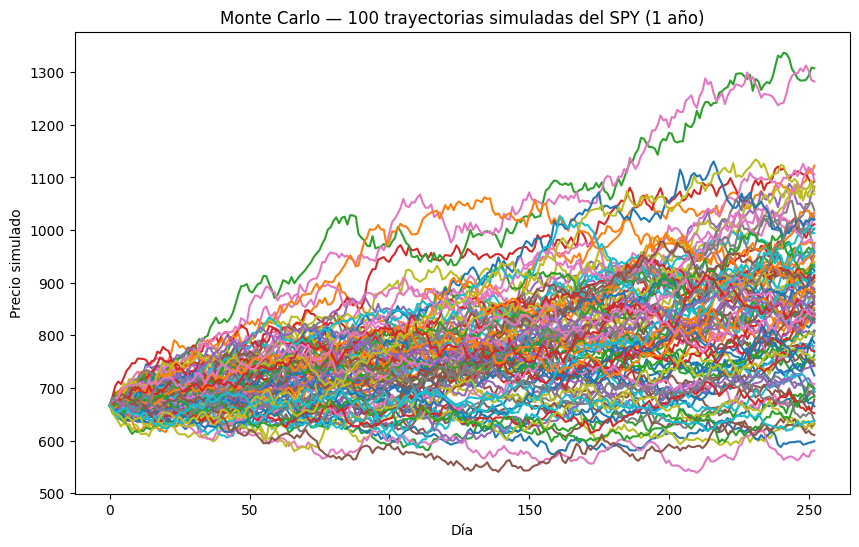

In [7]:
# 2. Con esos datos últimos, estimar los 1000 escenarios, aunque para el gráfico serán 100 líneas, por no saturar
S0 = float(prices.iloc[-1])   # precio inicial como escalar
mu = float(returns.mean())
sigma = float(returns.std(ddof=1))
S0 = float(prices.iloc[-1])   # precio inicial (float)
n_days = 252
n_sims = 1000
dt = 1.0

Z = np.random.normal(0, 1, size=(n_days, n_sims))

drift = (mu - 0.5 * sigma**2) * dt
diffusion = sigma * np.sqrt(dt) * Z

log_paths = np.vstack([np.zeros(n_sims), (drift + diffusion)]).cumsum(axis=0)

S_paths = S0 * np.exp(log_paths)

plt.figure(figsize=(10,6))
plt.plot(S_paths[:, :100])
plt.title("Monte Carlo — 100 trayectorias simuladas del SPY (1 año)")
plt.xlabel("Día")
plt.ylabel("Precio simulado")
plt.show()

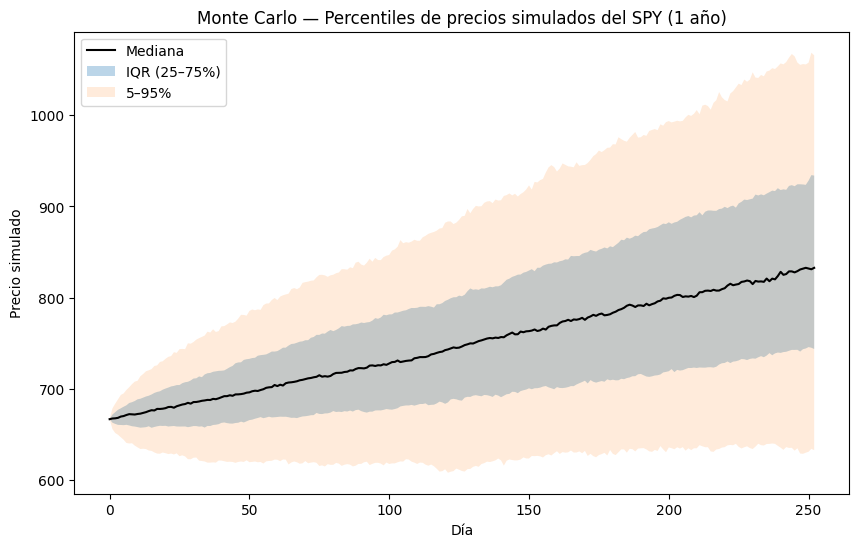

In [8]:
3# para ordenar: 
#Línea central (mediana).
#Banda 25–75% (escenarios más probables).
#Banda 5–95% (escenarios extremos).

# Percentiles diarios
p5  = np.percentile(S_paths, 5,  axis=1)
p25 = np.percentile(S_paths, 25, axis=1)
p50 = np.percentile(S_paths, 50, axis=1)   # mediana
p75 = np.percentile(S_paths, 75, axis=1)
p95 = np.percentile(S_paths, 95, axis=1)

plt.figure(figsize=(10,6))
plt.plot(p50, label="Mediana", color="black")
plt.fill_between(range(len(p25)), p25, p75, alpha=0.3, label="IQR (25–75%)")
plt.fill_between(range(len(p5)),  p5,  p95, alpha=0.15, label="5–95%")
plt.title("Monte Carlo — Percentiles de precios simulados del SPY (1 año)")
plt.xlabel("Día")
plt.ylabel("Precio simulado")
plt.legend()
plt.show()

Retorno 1 año — P5: -5.09% | Mediana: 24.88% | P95: 59.82%
P(perder más del 10% en 1 año): 2.0%
P(ganar más del 25% en 1 año): 49.5%


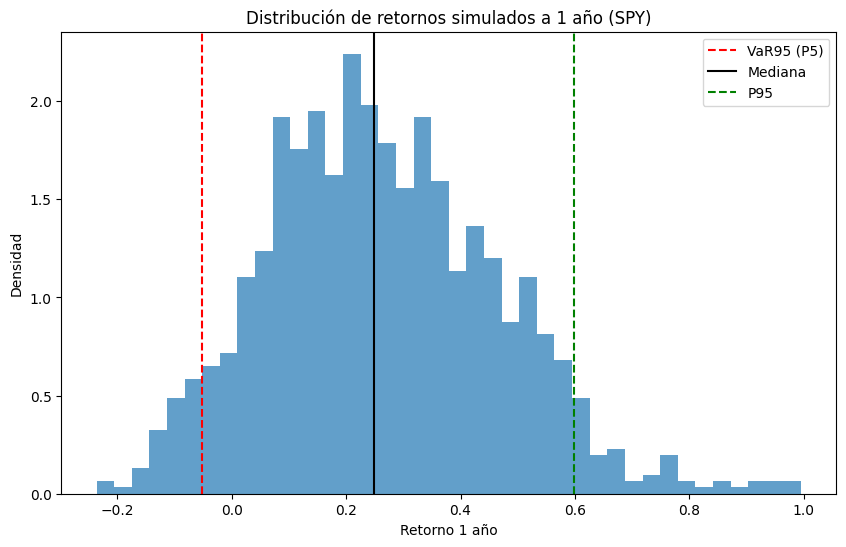

In [13]:
# Precio y retornos a 1 año
terminal_prices = S_paths[-1, :]
terminal_returns = terminal_prices / S0 - 1

# Percentiles clave
r_p5, r_p50, r_p95 = np.percentile(terminal_returns, [5, 50, 95])

# Probabilidades útiles
prob_caer_10 = (terminal_returns < -0.10).mean()
prob_subir_25 = (terminal_returns > 0.25).mean()

print(f"Retorno 1 año — P5: {r_p5:.2%} | Mediana: {r_p50:.2%} | P95: {r_p95:.2%}")
print(f"P(perder más del 10% en 1 año): {prob_caer_10:.1%}")
print(f"P(ganar más del 25% en 1 año): {prob_subir_25:.1%}")

# Histograma
plt.figure(figsize=(10,6))
plt.hist(terminal_returns, bins=40, density=True, alpha=0.7)
plt.axvline(r_p5, color="red", linestyle="--", label="VaR95 (P5)")
plt.axvline(r_p50, color="black", linestyle="-", label="Mediana")
plt.axvline(r_p95, color="green", linestyle="--", label="P95")
plt.title("Distribución de retornos simulados a 1 año (SPY)")
plt.xlabel("Retorno 1 año")
plt.ylabel("Densidad")
plt.legend()
plt.show()

In [10]:
var1y_95 = np.percentile(terminal_returns, 5)
cvar1y_95 = terminal_returns[terminal_returns <= var1y_95].mean()

print(f"VaR 1 año (95%): {var1y_95:.2%}")
print(f"CVaR 1 año (95%): {cvar1y_95:.2%}")

VaR 1 año (95%): -5.09%
CVaR 1 año (95%): -10.17%
